In [8]:
from transformers import BertForTokenClassification, BertPreTrainedModel, BertConfig, BertTokenizer, BertModel
from transformers import BertForSequenceClassification
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
import os
import re
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#加入CWC語料
#用誤代語料，然後產生標記檔 
news = open('1209\\newsCorpus.txt', 'r', encoding='utf-8')
err = open('1209\\對比資料庫.txt', 'r', encoding='utf-8')  
#test_err = open('1209\\test_err.txt', 'w', encoding='utf-8')
max_len = 110
err_type = []
        
test_label = []
with open('1209\\train_dataset.txt', 'w', encoding='utf-8') as train_data:
        t = {}
        e_num = 0
        while True: 
            err_line = err.readline()
            if not err_line:break
            lineTo = err_line.split(',')
            err_sen = lineTo[1].replace(' ','')
            if len(lineTo[1].replace(' ',''))<=3 and len(lineTo[0].replace(' ',''))<=3:continue
            #if err_sen.find(lineTo[11].replace(' ','')) < 0 or err_sen.count(lineTo[11].replace(' ',''))>1:continue
            if ('＆' in lineTo[1]) or ('&' in lineTo[1]) or ('+' in lineTo[1])  or ('＄' in lineTo[1]) or ('$' in lineTo[1]):continue
            if len(lineTo[0].replace(' ',''))>110:continue
            if len(lineTo)>0 : 
                if len(lineTo[9])==3:
                    if lineTo[9] in t.keys():t[lineTo[9]] += 1
                    else:t[lineTo[9]] = 1
                        
                if len(lineTo[9])==3:
                    if lineTo[9]=='MST':
                        err_sen = lineTo[1].split()
                        cor_sen = lineTo[0].split()
                        #print(err_sen, cor_sen)                        
                        
                        labels = ''
                        for i in range(len(err_sen)):
                            if cor_sen[i] != err_sen[i]:labels += '1'*len(err_sen[i])
                            else:labels += '0'*len(err_sen[i])
                        for i in range(max_len-len(lineTo[1].replace(' ',''))):
                            labels += '0'
                        
                        #train_data.write(lineTo[0].replace(' ','')+','+lineTo[1].replace(' ','')+','+labels+'\n')#寫修正句&偏誤句
                        train_data.write(lineTo[1].replace(' ','')+','+labels+','+lineTo[0].replace(' ','')+'\n')#寫誤代句
                        e_num += 1
        
        n_num = 0
        
        while True:
            labels = ''
            news_line = news.readline()
            if n_num >= 11261:break
            if not news_line:break
            for _ in range(max_len):labels += '0'
            train_data.write(news_line.replace('\n','') + ',' + labels + '\n')#寫新聞句            
            n_num += 1 
            
news.close()
err.close()
print(t, e_num, n_num)

{'OMS': 11523, 'MOD': 1995, 'MST': 11261, 'ADT': 8745, '009': 1} 11261 11261


In [69]:
e_num = 0
n_num = 0
confusion = open("1209\\字音混淆集.txt",'r',encoding='utf-8') #經過字形與字音相似度計算後，為相似字的表

dict={}
while(True):
    line = confusion.readline().strip()
    
    if line:
        line = line.split('　')
        if len(line)!=1:
            dict[line[0]] = line[1]
        
    else:
        break
confusion.close()

table = open("1209\\wordtest4.txt",'r',encoding='utf-8') #要挑的字表
s=0
dict2={}

while(True):
    line = table.readline().strip()
    
    if not line:break
    line = line.split(',')
    dict2[s] = line[0]
    s+=1
        
table.close()

import random
max_len = 110
def test_(c): #產生錯字
    if random.random() <= 0.8: #有0.8的機率是相似的錯字
        line = dict[c].split(' ')
        return line[random.randint(0,len(line)-1)]
    else:    #有0.2的機率是隨機抽字
        a = random.randint(0,len(dict2)-1)
        while(c==dict2[a]):
            a = random.randint(0,len(dict2)-1)
        return dict2[a]

file =  open("1209\\newsCorpus.txt",'r',encoding='utf-8') #要被變成訓練資料的句子，也是校正層解答
answer_list=''
a=0
file2 =  open("1209\\train_dataset.txt",'w',encoding='utf-8') #產生的訓練資料句

while True:
    
    line2=''
    answer=[]
    line = file.readline()
    if not line:break
    if e_num >= 200000: break
    for ch in ['， ', ', ', ' ,', ',']:#
        line = line.replace(ch, '，')
    line = line.replace('︵', '(')
    line = line.replace('︶', ')')
    line = line.replace(':', '：')
    if len(line)>max_len:continue
    e_num += 1
    for i in line.replace('\n', ''):
        if a==0:
            if random.randint(1,15) == 10: #有1/15的機率 把這個字當成錯字
                a+=1
                if dict.get(i) != None: #若這個字不再字表中，則選擇下一個字為錯字 會有a去計數
                    line2+=test_(i)
                    a-=1
                    answer.append(1)
                else:
                    line2+=i
                    answer.append(0)
            else:
                line2+=i
                answer.append(0)
                
        else:   #若a>0以上，則要一直挑錯字，直到a==0
            if dict.get(i) != None: #
                line2+=test_(i)
                a-=1
                answer.append(1)
            else:
                line2+=i
                answer.append(0)
                
    for j in answer:  #寫入答案
        answer_list+=str(j)
    for i in range(max_len-len(answer_list)):answer_list += '0'
    file2.write(line2 + ',' + answer_list + '\n')
    answer_list=''
'''
news = open('1209\\newsCorpus.txt', 'r', encoding='utf-8')
n_num = 0
while True:
    labels = ''
    news_line = news.readline()
    if not news_line:break
    if n_num >= 1e5:break
    for _ in range(max_len):labels += '0'
    file2.write(news_line.replace('\n','') + ',' + labels + '\n')#寫新聞句 
    n_num += 1
    
news.close()
'''
file2.close()  
file.close()
print(e_num, n_num)

200000 0


In [5]:
def write_Wrong_word():
    MAX_LEN = 110
    e_num = 0
    n_num = 0
    confusion = open("1209\\字音混淆集.txt",'r',encoding='utf-8') #經過字形與字音相似度計算後，為相似字的表

    dict={}
    while(True):
        line = confusion.readline().strip()
        
        if not line:break
        line = line.split('　')
        if len(line)!=1:dict[line[0]] = line[1]
          
    confusion.close()

    table = open("1209\\wordtest4.txt",'r',encoding='utf-8') #要挑的字表
    s=0
    dict2={}

    while(True):
        line = table.readline().strip()
        
        if not line:break
        line = line.split(',')
        dict2[s] = line[0]
        s+=1
            
    table.close()

    import random
    def test_(c, prob): #產生錯字
        prob /= 0.15
        if prob < 0.8:
        #if np.random.choice([True, False], p=[0.8, 0.2]): #有0.8的機率是相似的錯字
            line = dict[c].split(' ')
            return line[random.randint(0,len(line)-1)]
        else:    #有0.2的機率是隨機抽字
            a = random.randint(0,len(dict2)-1)
            while(c==dict2[a]):
                a = random.randint(0,len(dict2)-1)
            return dict2[a]
    
    file = open("1209\\newsCorpus.txt",'r',encoding='utf-8') #要被變成訓練資料的句子，也是校正層解答
    answer_list=''
    a=0
    file2 = open("1209\\train_dataset.txt",'w',encoding='utf-8') #產生的訓練資料句

    while True:
        
        line2=''
        answer=[]
        line = file.readline()
        if not line:break
        if e_num >= 2e4:
            '''
            n_num = 0
            while True:
                
                labels = ''
                news_line = file.readline()
                if not news_line:break
                if n_num >= 2e4:break
                for _ in range(MAX_LEN):labels += '0'
                file2.write(news_line.replace('\n','') + ',' + labels + '\n')#寫新聞句 
                n_num += 1
            '''
            break
        for ch in ['， ', ', ', ' ,', ',']:#
            line = line.replace(ch, '，')
        line = line.replace('︵', '(')
        line = line.replace('︶', ')')
        line = line.replace(':', '：')
        if len(line)>MAX_LEN:continue
        e_num += 1
        for i in line.replace('\n', ''):
            if a==0:
                prob = random.random()
                if prob<=0.15:#有1/15的機率 把這個字當成錯字
                #if np.random.choice([True, False], p=[0.15, 0.85]): 
                    a+=1
                    if dict.get(i) != None: #若這個字不再字表中，則選擇下一個字為錯字 會有a去計數
                        line2+=test_(i, prob)
                        a-=1
                        answer.append(1)
                    else:
                        line2+=i
                        answer.append(0)
                else:
                    line2+=i
                    answer.append(0)
                    
            else:   #若a>0以上，則要一直挑錯字，直到a==0
                if dict.get(i) != None: #
                    line2+=test_(i, prob)
                    a-=1
                    answer.append(1)
                else:
                    line2+=i
                    answer.append(0)
                    
        for j in answer:  #寫入答案
            answer_list+=str(j)
        for i in range(MAX_LEN-len(answer_list)):answer_list += '0'
        file2.write(line2 + ',' + answer_list + '\n')
        file2.write(line.replace('\n', '') + ',' + ''.join([str(0) for i in range(MAX_LEN)]) + '\n')
        answer_list=''
    file2.close()  
    file.close()
    print(e_num, n_num)
    
write_Wrong_word()

40000 0


In [6]:
from sklearn.model_selection import train_test_split
x, y = [], []
with open('1209\\train_dataset.txt', 'r', encoding='utf-8') as train_data:
    while True:
        line = train_data.readline()
        if not line:break
        line = line.replace('\n', '')
        data = line.split(',')
        x.append(data[0])
        y.append(1 if '1' in data[1] else 0)
        #y.append([int(i) for i in data[1]])


x_train, x_val, y_train, y_val =\
    train_test_split(x, y, test_size=0.00075, random_state=2021)
print(x_train[:2], x_val[:2], y_train[:2], y_val[:2], len(x_train), len(x_val))


['例如煤炭堆積待運量佔年產量的三成之多，致使四億噸煤無法自產地運出，每年減少出口的煤炭達六百萬到一千萬噸，出口損失兩億到三億五千萬元。', '基隆釋警鞠表示，忠東戰爭爆發，渭確寶斜內外僑安全與社會治氨，井方已奉命全面加強執行外極勞工專案，呼籲廠商步要殷外籍勞工工價較菸，而予以僱拐，滋濕治安問題。'] ['結果春耕一延再延，大批稻作無法插秧，更嚴重的是，許多旱栽作物，如華南山區的高地稻米，也因雨量太少不能播種。', '花蓮縣務會議，今天上午在花蓮縣政府召開，由花蓮縣長吳國棟主持。'] [0, 1] [0, 0] 79940 60


In [9]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [10]:
MAX_LEN = 110
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
def preprocessing_for_bert(data):
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=False,
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)

    return input_ids

In [11]:
def preprocessing_for_bert_At(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [10]:
#train_inputs = preprocessing_for_bert(x_train)
#val_inputs = preprocessing_for_bert(x_val)

train_inputs, train_masks = preprocessing_for_bert_At(x_train)
val_inputs, val_masks = preprocessing_for_bert_At(x_val)
print(train_inputs[:2])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\islab\Anaconda3\envs\pytorch\lib\site-packages\transformers-4.1.1-py3.8.egg\transformers\tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


tensor([[ 101,  891, 1963, 4209, 4151, 1831, 4948, 2521, 6880, 7030,  861, 2399,
         4496, 7030, 4638,  676, 2768,  722, 1914, 8024, 5636,  886, 1724, 1023,
         1697, 4209, 4192, 3791, 5632, 4496, 1765, 6880, 1139, 8024, 3680, 2399,
         3938, 2208, 1139, 1366, 4638, 4209, 4151, 6888, 1063, 4636, 5857, 1168,
          671, 1283, 5857, 1697, 8024, 1139, 1366, 3010, 1927, 1060, 1023, 1168,
          676, 1023,  758, 1283, 5857, 1039,  511,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [ 101, 1825, 7384, 7026, 6356, 7495, 6134, 4850, 8024, 2566, 3346, 2782,
         4261, 4255, 4634, 8024, 3948, 4825, 2188, 3162, 1058, 1912, 1009, 2128,
         1059, 5645, 4852, 3298, 3780, 3710, 8024,  759, 3175, 2347, 1938, 1462,
      

In [11]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 64

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_labels, train_masks)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_labels, val_masks)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
train_data[:3], tokenizer.decode(train_data[:1][0][0]), val_data[:3], tokenizer.decode(val_data[:1][0][0])

((tensor([[ 101,  891, 1963, 4209, 4151, 1831, 4948, 2521, 6880, 7030,  861, 2399,
           4496, 7030, 4638,  676, 2768,  722, 1914, 8024, 5636,  886, 1724, 1023,
           1697, 4209, 4192, 3791, 5632, 4496, 1765, 6880, 1139, 8024, 3680, 2399,
           3938, 2208, 1139, 1366, 4638, 4209, 4151, 6888, 1063, 4636, 5857, 1168,
            671, 1283, 5857, 1697, 8024, 1139, 1366, 3010, 1927, 1060, 1023, 1168,
            676, 1023,  758, 1283, 5857, 1039,  511,  102,    0,    0,    0,    0,
              0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
              0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
              0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
              0,    0],
          [ 101, 1825, 7384, 7026, 6356, 7495, 6134, 4850, 8024, 2566, 3346, 2782,
           4261, 4255, 4634, 8024, 3948, 4825, 2188, 3162, 1058, 1912, 1009, 2128,
           1059, 5645, 4852, 3298, 3780, 3710, 8024,  759, 3175

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


In [15]:
class BertSeqClassifier(nn.Module):
    """
    Bert Model for Classification Tasks.
    """
    def __init__(self, model_name, freeze_bert=False):
        super(BertSeqClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained(model_name)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, labels, attention_mask):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]
    
        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits, labels)
        return TokenClassifierOutput(
            loss=loss,
            logits=logits
        )

In [14]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    
    #model = BertForTokenClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)
    #model = BertClassifier(PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)
    model = BertSeqClassifier(PRETRAINED_MODEL_NAME)
    # Tell PyTorch to run the model on GPU
    model = model.to(device)

    # Create the optimizer
    optimizer = AdamW(model.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return model, optimizer, scheduler

In [15]:
import random
import time

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [16]:
def train(model, train_dataloader, val_dataloader, epochs=4):
    Loss = []    
    model.train() #訓練模式
    for i in tqdm(range(epochs)):  
        model.train() #訓練模式
        batch_counts = 0
        running_loss = 0.0
        for step, batch in enumerate(train_dataloader): #訓練資料
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_labels, b_masks = tuple(t.to(device) for t in batch)
            optimizer.zero_grad()
            out = model(input_ids=b_input_ids, labels=b_labels, attention_mask=b_masks)
            loss = out[0]
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
        torch.save(model.state_dict(), 'ckpt/bert_seq_error_cor_same_half2W_weight_'+str(i+1)+'.h5')
        Loss.append(running_loss)
        val_loss, val_acc = evaluate(model, val_dataloader)
        print('[epoch %d] train_loss: %.3f val_loss: %.3f val_acc: %.3f' % (i + 1, running_loss, val_loss, val_acc))
    return Loss

PRETRAINED_MODEL_NAME = "bert-base-chinese"
NUM_LABELS = 2
epochs = 20
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs)
losses = train(bert_classifier, train_dataloader, val_dataloader, epochs)

  5%|████                                                                            | 1/20 [13:06<4:09:04, 786.53s/it]

[epoch 1] loss: 57.272


 10%|████████                                                                        | 2/20 [26:20<3:56:38, 788.81s/it]

[epoch 2] loss: 23.731


 15%|████████████                                                                    | 3/20 [39:32<3:43:46, 789.78s/it]

[epoch 3] loss: 14.010


 20%|████████████████                                                                | 4/20 [52:44<3:30:45, 790.35s/it]

[epoch 4] loss: 10.243


 25%|███████████████████▌                                                          | 5/20 [1:05:55<3:17:39, 790.65s/it]

[epoch 5] loss: 10.042


 30%|███████████████████████▍                                                      | 6/20 [1:19:06<3:04:30, 790.78s/it]

[epoch 6] loss: 8.539


 35%|███████████████████████████▎                                                  | 7/20 [1:32:17<2:51:20, 790.84s/it]

[epoch 7] loss: 6.608


 40%|███████████████████████████████▏                                              | 8/20 [1:45:29<2:38:11, 790.96s/it]

[epoch 8] loss: 5.368


 45%|███████████████████████████████████                                           | 9/20 [1:58:40<2:25:00, 790.98s/it]

[epoch 9] loss: 6.968


 50%|██████████████████████████████████████▌                                      | 10/20 [2:11:50<2:11:49, 790.93s/it]

[epoch 10] loss: 4.351


 55%|██████████████████████████████████████████▎                                  | 11/20 [2:25:01<1:58:38, 790.89s/it]

[epoch 11] loss: 4.291


 60%|██████████████████████████████████████████████▏                              | 12/20 [2:38:12<1:45:27, 790.88s/it]

[epoch 12] loss: 3.392


 65%|██████████████████████████████████████████████████                           | 13/20 [2:51:23<1:32:15, 790.80s/it]

[epoch 13] loss: 3.528


 70%|█████████████████████████████████████████████████████▉                       | 14/20 [3:04:32<1:19:02, 790.42s/it]

[epoch 14] loss: 3.789


 75%|█████████████████████████████████████████████████████████▊                   | 15/20 [3:17:43<1:05:52, 790.56s/it]

[epoch 15] loss: 3.110


 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [3:30:54<52:42, 790.62s/it]

[epoch 16] loss: 1.651


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [3:44:03<39:30, 790.27s/it]

[epoch 17] loss: 0.968


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [3:57:03<26:14, 787.01s/it]

[epoch 18] loss: 0.683


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [4:09:52<13:01, 781.64s/it]

[epoch 19] loss: 0.441


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [4:22:49<00:00, 788.48s/it]

[epoch 20] loss: 0.488


[57.272134136990644, 23.731054754549405, 14.010025119845523, 10.242651909535198, 10.041859910175845, 8.539342644355202, 6.608067794844828, 5.36839998159121, 6.968256751606532, 4.351226615741325, 4.29094233194337, 3.3915825955336913, 3.528080198695534, 3.7888826420748956, 3.109523358551087, 1.6513890810747398, 0.9680189694954606, 0.6829484997815598, 0.44084791727254924, 0.4881493357788713]


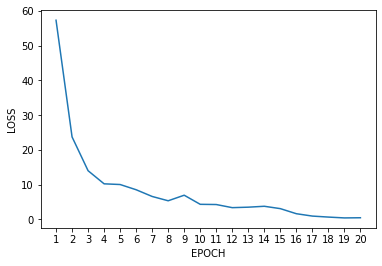

In [17]:
import math
print(losses)
x = np.arange(1, len(losses)+1)
y = losses
plt.xlabel('EPOCH')
plt.ylabel('LOSS')  
plt.xticks(x)
plt.plot(x, y)
plt.savefig('test/BertSeqTransloss{}.jpg'.format(epochs))
plt.show()

In [27]:
import numpy as np
import pandas as pd
import random
mode = "sentence1times_eWord"

def get_test_result(dataloader):
    y_real_s = []
    y_pred_s = []
    cor_count = 0
    
    data = {
    "真實標記":[],
    "預測標記":[]
    }
    
    for batch in dataloader:
        # Load batch to GPU
        b_input_ids, b_labels, b_masks = tuple(t.to(device) for t in batch)    

        # Compute logits
        with torch.no_grad():
            logits = bert_classifier(input_ids = b_input_ids, labels = b_labels, attention_mask=b_masks)    
        # Compute loss
        loss = logits[0]

        # Get the predictions    
        pred = torch.max(logits[1], 1)[1].data
        y_pred_s += list(pred.cpu().numpy())          
        y_real_s += list(b_labels.cpu().numpy())

        #sentence = tokenizer.decode(b_input_ids)
    #df = pd.DataFrame(data)
    return  y_real_s, y_pred_s

# Compute the average accuracy and loss over the validation set.

#y_real_s, y_pred_s = get_test_result(val_dataloader)

#df.to_csv('test/Bert{}EpochErr_{}.csv'.format(epochs,mode))
#df


In [ ]:
def get_test_result(dataloader):
    y_real_s = []
    y_pred_s = []
    cor_count = 0
    
    data = {
    "真實標記":[],
    "預測標記":[]
    }
    
    for batch in dataloader:
        # Load batch to GPU
        b_input_ids, b_labels, b_mask = tuple(t.to(device) for t in batch)    

        # Compute logits
        with torch.no_grad():
            logits = bert_classifier(input_ids = b_input_ids, labels = b_labels)    
        # Compute loss
        loss = logits[0]

        # Get the predictions    

        for logit, real, b_input_id in zip(logits[1], b_labels, b_input_ids):
            token = [int(i) for i in b_input_id.cpu().numpy() if i != 0] 
            pred = torch.max(logit, 1)[1].data
            sentence = tokenizer.decode(b_input_id[:len(token)]) #轉成中文句
            realList = sentence.split()
            predList = sentence.split()
            predLabel = torch.nonzero(pred)
            realLabel = torch.nonzero(real)

            if realLabel.size()[0] != 0:
                if realLabel[0].cpu().numpy() >= len(realList):continue
                if realLabel[-1].cpu().numpy() >= len(realList):continue

            if predLabel.size()[0] != 0:
                if predLabel[0].cpu().numpy() >= len(predList):continue
                if predLabel[-1].cpu().numpy() >= len(predList):continue  

            if predLabel.size()[0] == 1:            
                predList[predLabel[0]] = '['+predList[predLabel[0]]+']'
            elif predLabel.size()[0] > 1:
                for i in predLabel:
                    predList[i[0]] = '['+predList[i[0]]+']'
            data["預測標記"].append(''.join(predList)) 

            if realLabel.size()[0] == 1:            
                realList[realLabel[0][0]] = '['+realList[realLabel[0][0]]+']'
            elif realLabel.size()[0] > 1:
                for i in realLabel:
                    realList[i[0]] = '['+realList[i[0]]+']'
            data["真實標記"].append(''.join(realList))

            corr = torch.zeros((1,max_len)).type(torch.int64)
            corr = corr.to(device)

            if torch.equal(real, corr[0]):y_real_s += [1]
            else:y_real_s += [0]

            if torch.equal(pred, corr[0]):y_pred_s += [1] 
            elif torch.equal(pred, real):
                y_pred_s += [0]
                cor_count += 1
            else:
                y_pred_s += [0]

        #sentence = tokenizer.decode(b_input_ids)
    df = pd.DataFrame(data)
    return cor_count, df, y_real_s, y_pred_s

# Compute the average accuracy and loss over the validation set.

cor_count, df, y_real_s, y_pred_s = get_test_result(val_dataloader)
print(cor_count)
df.to_csv('test/Bert{}EpochErr_{}.csv'.format(epochs,mode))
df


In [42]:
PRETRAINED_MODEL_NAME = "bert-base-chinese"
bert_classifier = BertSeqClassifier(PRETRAINED_MODEL_NAME)
# Tell PyTorch to run the model on GPU
bert_classifier = bert_classifier.to(device)

checkpoint = torch.load('ckpt/bert_seq_only_err4W_weight_20.h5')
bert_classifier.load_state_dict(checkpoint)
bert_classifier.eval()

BertSeqClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def show_confusion(y_real_s, y_pred_s):
    confmat_s = confusion_matrix(y_true=y_real_s, y_pred=y_pred_s)
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat_s, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat_s.shape[0]):
        for j in range(confmat_s.shape[1]):
            ax.text(x=j, y=i, s=confmat_s[i,j], va='center', ha='center')
    
    cm_s = {'tp': confmat_s[1, 1], 'fn': confmat_s[1, 0], 'fp': confmat_s[0, 1], 'tn': confmat_s[0, 0]}
    total = sum(cm_s.values())
    print('--------------Detection level--------------')
    print("accuracy:", (cm_s['tp']+cm_s['tn'])/total)

    recall = (cm_s['tp'])/(cm_s['tp']+cm_s['fn'])
    print("recall:", recall)

    precision = (cm_s['tp'])/(cm_s['tp']+cm_s['fp'])
    print("precision:", precision)

    print("f1-score:", 2/((1/precision)+(1/recall)))

    fa_rate = (cm_s['fp'])/(cm_s['tn']+cm_s['fp'])
    print("FA-Rate:", fa_rate)
    plt.xlabel('Prediction')        
    plt.ylabel('Real Label')
    plt.show()
    
#show_confusion(y_real_s, y_pred_s)

torch.Size([699]) torch.Size([699, 110])
--------------Detection level--------------
accuracy: 0.4492131616595136
recall: 0.9769736842105263
precision: 0.44
f1-score: 0.6067415730337078
FA-Rate: 0.9569620253164557


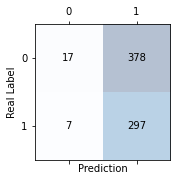

In [44]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 64
labels, texts = [], []
with open("1209\\中央社已處理\\test_answer_13.txt",'r',encoding='utf-8') as label:
    while True:
        line = label.readline().strip()
        if not line:break
        labels.append(1 if '1' in line else 0)
        #labels.append([int(i) for i in line]+[0 for j in range(MAX_LEN - len(line))])
    
with open("1209\\中央社已處理\\test_input_13.txt",'r',encoding='utf-8') as text:    
    while True:
        line = text.readline().strip()
        if not line:break
        texts.append(line)
'''       
with open("1209\\testCorpus.txt",'r',encoding='utf-8') as test:
    while True:
        line = test.readline().strip()
        if not line:break
        texts.append(line)
        labels.append([0 for j in range(MAX_LEN)])
''' 
        
test_inputs, test_masks = preprocessing_for_bert_At(texts)
test_labels = torch.tensor(labels)
print(test_labels.size(), test_inputs.size())

test_data = TensorDataset(test_inputs, test_labels, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

#cor_count, df, y_real_s, y_pred_s = get_test_result(test_dataloader)
y_real_s, y_pred_s = get_test_result(test_dataloader)
show_confusion(y_real_s, y_pred_s)
#df.to_csv('test/Bert20WLSTMSIGHAN2014.csv'.format(epochs,mode))
#df

torch.Size([778]) torch.Size([778, 110])
--------------Detection level--------------
accuracy: 0.5154241645244216
recall: 0.9333333333333333
precision: 0.509090909090909
f1-score: 0.6588235294117647
FA-Rate: 0.904639175257732


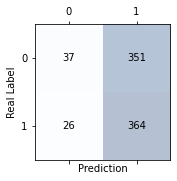

In [45]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 64
labels, texts = [], []
with open("1209\\中央社已處理\\test_answer_14.txt",'r',encoding='utf-8') as label:
    while True:
        line = label.readline().strip()
        if not line:break
        labels.append(1 if '1' in line else 0)
        #labels.append([int(i) for i in line]+[0 for j in range(MAX_LEN - len(line))])
    
with open("1209\\中央社已處理\\test_input_14.txt",'r',encoding='utf-8') as text:    
    while True:
        line = text.readline().strip()
        if not line:break
        texts.append(line)
'''       
with open("1209\\testCorpus.txt",'r',encoding='utf-8') as test:
    while True:
        line = test.readline().strip()
        if not line:break
        texts.append(line)
        labels.append([0 for j in range(MAX_LEN)])
''' 
        
test_inputs, test_masks = preprocessing_for_bert_At(texts)
test_labels = torch.tensor(labels)
print(test_labels.size(), test_inputs.size())

test_data = TensorDataset(test_inputs, test_labels, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

#cor_count, df, y_real_s, y_pred_s = get_test_result(test_dataloader)
y_real_s, y_pred_s = get_test_result(test_dataloader)
show_confusion(y_real_s, y_pred_s)
#df.to_csv('test/Bert20WLSTMSIGHAN2014.csv'.format(epochs,mode))
#df

torch.Size([1072]) torch.Size([1072, 110])
--------------Detection level--------------
accuracy: 0.5242537313432836
recall: 0.8689138576779026
precision: 0.5132743362831859
f1-score: 0.6453407510431155
FA-Rate: 0.8178438661710037


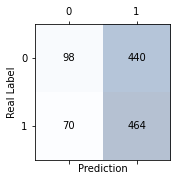

In [46]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 64
labels, texts = [], []
with open("1209\\中央社已處理\\test_answer_15.txt",'r',encoding='utf-8') as label:
    while True:
        line = label.readline().strip()
        if not line:break
        labels.append(1 if '1' in line else 0)
        #labels.append([int(i) for i in line]+[0 for j in range(MAX_LEN - len(line))])
    
with open("1209\\中央社已處理\\test_input_15.txt",'r',encoding='utf-8') as text:    
    while True:
        line = text.readline().strip()
        if not line:break
        texts.append(line)
'''       
with open("1209\\testCorpus.txt",'r',encoding='utf-8') as test:
    while True:
        line = test.readline().strip()
        if not line:break
        texts.append(line)
        labels.append([0 for j in range(MAX_LEN)])
''' 
        
test_inputs, test_masks = preprocessing_for_bert_At(texts)
test_labels = torch.tensor(labels)
print(test_labels.size(), test_inputs.size())

test_data = TensorDataset(test_inputs, test_labels, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

#cor_count, df, y_real_s, y_pred_s = get_test_result(test_dataloader)
y_real_s, y_pred_s = get_test_result(test_dataloader)
show_confusion(y_real_s, y_pred_s)
#df.to_csv('test/Bert20WLSTMSIGHAN2014.csv'.format(epochs,mode))
#df